<a href="https://colab.research.google.com/github/MEskerod/RNA_UNET/blob/main/experiments/RNAUnet_experiment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os, torch, pickle, tarfile, sys

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from collections import namedtuple

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
sys.path.append('/content/drive/MyDrive')
import utils

# Functions

## Models

In [4]:
class DynamicPadLayer(nn.Module):
  """
  """
  def __init__(self, stride_product):
    super(DynamicPadLayer, self).__init__()
    self.stride_product = stride_product

  def forward(self, x):
    input_size = x.shape[2]
    padding = self.calculate_padding(input_size, self.stride_product)
    return nn.functional.pad(x, padding)

  def calculate_padding(self, input_size, stride_product):
    p = stride_product - input_size % stride_product
    return (0, p, 0, p)

class MaxPooling(nn.Module):
  """
  Layer for max pooling
  """
  def __init__(self, in_channels, out_channels, kernel_size=2, stride=2, padding=0):
    super(MaxPooling, self).__init__()
    self.max_pool = nn.MaxPool2d(kernel_size = kernel_size, stride = stride)

  def forward(self, x):
    return self.max_pool(x)

In [5]:
class RNA_Unet_large(nn.Module):
    def __init__(self, channels=32, in_channels=8, output_channels=1, negative_slope = 0.01, pooling = MaxPooling):
        """
        args:
        num_channels: length of the one-hot encoding vector
        num_hidden_channels: number of channels in the hidden layers of both encoder and decoder
        """
        super(RNA_Unet_large, self).__init__()

        self.negative_slope = negative_slope

        self.pad = DynamicPadLayer(2**4)

        # Encoder
        self.bn11 = nn.BatchNorm2d(channels)
        self.e11 = nn.Conv2d(in_channels, channels, kernel_size = 3, padding = 1)
        self.bn12 = nn.BatchNorm2d(channels)
        self.e12 = nn.Conv2d(channels, channels, kernel_size = 3, padding = 1)
        self.pool1 = pooling(channels, channels, kernel_size=2, stride=2)

        self.bn21 = nn.BatchNorm2d(channels * 2)
        self.e21 = nn.Conv2d(channels, channels*2, kernel_size=3, padding=1)
        self.bn22 = nn.BatchNorm2d(channels * 2)
        self.e22 = nn.Conv2d(channels*2, channels*2, kernel_size=3, padding=1)
        self.pool2 = pooling(channels*2, channels*2, kernel_size=2, stride=2)

        self.bn31 = nn.BatchNorm2d(channels*4)
        self.e31 = nn.Conv2d(channels*2, channels*4, kernel_size=3, padding=1)
        self.bn32 = nn.BatchNorm2d(channels*4)
        self.e32 = nn.Conv2d(channels*4, channels*4, kernel_size=3, padding=1)
        self.pool3 = pooling(channels*4, channels*4, kernel_size=2, stride=2)

        self.bn41 = nn.BatchNorm2d(channels*8)
        self.e41 = nn.Conv2d(channels*4, channels*8, kernel_size=3, padding=1)
        self.bn42 = nn.BatchNorm2d(channels*8)
        self.e42 = nn.Conv2d(channels*8, channels*8, kernel_size=3, padding=1)
        self.pool4 = pooling(channels*8, channels*8, kernel_size=2, stride=2)

        self.bn51 = nn.BatchNorm2d(channels*16)
        self.e51 = nn.Conv2d(channels*8, channels*16, kernel_size=3, padding=1)
        self.bn52 = nn.BatchNorm2d(channels*16)
        self.e52 = nn.Conv2d(channels*16, channels*16, kernel_size=3, padding=1)

        #Decoder
        self.bn61 = nn.BatchNorm2d(channels*8)
        self.upconv1 = nn.ConvTranspose2d(channels*16, channels*8, kernel_size=2, stride=2)
        self.bn62 = nn.BatchNorm2d(channels*8)
        self.d11 = nn.Conv2d(channels*16, channels*8, kernel_size=3, padding=1)
        self.bn63 = nn.BatchNorm2d(channels*8)
        self.d12 = nn.Conv2d(channels*8, channels*8, kernel_size=3, padding=1)

        self.bn71 = nn.BatchNorm2d(channels*4)
        self.upconv2 = nn.ConvTranspose2d(channels*8, channels*4, kernel_size=2, stride=2)
        self.bn72 = nn.BatchNorm2d(channels*4)
        self.d21 = nn.Conv2d(channels*8, channels*4, kernel_size=3, padding=1)
        self.bn73 = nn.BatchNorm2d(channels*4)
        self.d22 = nn.Conv2d(channels*4, channels*4, kernel_size=3, padding=1)

        self.bn81 = nn.BatchNorm2d(channels*2)
        self.upconv3 = nn.ConvTranspose2d(channels*4, channels*2, kernel_size=2, stride=2)
        self.bn82 = nn.BatchNorm2d(channels*2)
        self.d31 = nn.Conv2d(channels*4, channels*2, kernel_size=3, padding=1)
        self.bn83 = nn.BatchNorm2d(channels*2)
        self.d32 = nn.Conv2d(channels*2, channels*2, kernel_size=3, padding=1)

        self.bn91 = nn.BatchNorm2d(channels)
        self.upconv4 = nn.ConvTranspose2d(channels*2, channels, kernel_size=2, stride=2)
        self.bn92 = nn.BatchNorm2d(channels)
        self.d41 = nn.Conv2d(channels*2, channels, kernel_size=3, padding=1)
        self.bn93 = nn.BatchNorm2d(channels)
        self.d42 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)

        self.out = nn.Sequential(nn.Conv2d(channels, output_channels, kernel_size=1),
                                 nn.Sigmoid())

        # Initialize weights
        self.init_weights()

    def init_weights(self):
      for layer in self.modules():
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.ConvTranspose2d):
          gain = nn.init.calculate_gain("leaky_relu", self.negative_slope)
          nn.init.xavier_uniform_(layer.weight, gain=gain)
          nn.init.zeros_(layer.bias)
        elif isinstance(layer, nn.BatchNorm2d):
          nn.init.constant_(layer.weight, 1)
          nn.init.constant_(layer.bias, 0)


    def forward(self, x):
        dim = x.shape[2]
        x = self.pad(x)

        #Encoder
        xe11 = F.leaky_relu(self.bn11(self.e11(x)), negative_slope=self.negative_slope)
        xe12 = F.leaky_relu(self.bn12(self.e12(xe11)), negative_slope=self.negative_slope)
        xp1 = self.pool1(xe12)

        xe21 = F.leaky_relu(self.bn21(self.e21(xp1)), negative_slope=self.negative_slope)
        xe22 = F.leaky_relu(self.bn22(self.e22(xe21)), negative_slope=self.negative_slope)
        xp2 = self.pool2(xe22)

        xe31 = F.leaky_relu(self.bn31(self.e31(xp2)), negative_slope=self.negative_slope)
        xe32 = F.leaky_relu(self.bn32(self.e32(xe31)), negative_slope=self.negative_slope)
        xp3 = self.pool3(xe32)

        xe41 = F.leaky_relu(self.bn41(self.e41(xp3)), negative_slope=self.negative_slope)
        xe42 = F.leaky_relu(self.bn42(self.e42(xe41)), negative_slope=self.negative_slope)
        xp4 = self.pool4(xe42)

        xe51 = F.leaky_relu(self.bn51(self.e51(xp4)), negative_slope=self.negative_slope)
        xe52 = F.leaky_relu(self.bn52(self.e52(xe51)), negative_slope=self.negative_slope)

        #Decoder
        xu1 = F.leaky_relu(self.bn61(self.upconv1(xe52)), negative_slope=self.negative_slope)
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = F.leaky_relu(self.bn62(self.d11(xu11)), negative_slope=self.negative_slope)
        xd12 = F.leaky_relu(self.bn63(self.d12(xd11)), negative_slope=self.negative_slope)

        xu2 = F.leaky_relu(self.bn71(self.upconv2(xd12)), negative_slope=self.negative_slope)
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = F.leaky_relu(self.bn72(self.d21(xu22)), negative_slope=self.negative_slope)
        xd22 = F.leaky_relu(self.bn73(self.d22(xd21)), negative_slope=self.negative_slope)

        xu3 = F.leaky_relu(self.bn81(self.upconv3(xd22)), negative_slope=self.negative_slope)
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = F.leaky_relu(self.bn81(self.d31(xu33)), negative_slope=self.negative_slope)
        xd32 = F.leaky_relu(self.bn83(self.d32(xd31)), negative_slope=self.negative_slope)

        xu4 = F.leaky_relu(self.bn91(self.upconv4(xd32)), negative_slope=self.negative_slope)
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = F.leaky_relu(self.bn92(self.d41(xu44)), negative_slope=self.negative_slope)
        xd42 = F.leaky_relu(self.bn93(self.d42(xd41)), negative_slope=self.negative_slope)

        out = self.out(xd42)

        out = out[:, :, :dim, :dim]

        return out

In [6]:
class RNA_Unet_multi(nn.Module):
    def __init__(self, channels=32, in_channels=8, output_channels=1, classes = 8, negative_slope = 0.01, pooling = MaxPooling):
        """
        args:
        num_channels: length of the one-hot encoding vector
        num_hidden_channels: number of channels in the hidden layers of both encoder and decoder
        """
        super(RNA_Unet_multi, self).__init__()

        self.negative_slope = negative_slope

        self.pad = DynamicPadLayer(2**4)

        # Encoder
        self.bn11 = nn.BatchNorm2d(channels)
        self.e11 = nn.Conv2d(in_channels, channels, kernel_size = 3, padding = 1)
        self.pool1 = pooling(channels, channels, kernel_size=2, stride=2)

        self.bn21 = nn.BatchNorm2d(channels * 2)
        self.e21 = nn.Conv2d(channels, channels*2, kernel_size=3, padding=1)
        self.pool2 = pooling(channels*2, channels*2, kernel_size=2, stride=2)

        self.bn31 = nn.BatchNorm2d(channels*4)
        self.e31 = nn.Conv2d(channels*2, channels*4, kernel_size=3, padding=1)
        self.pool3 = pooling(channels*4, channels*4, kernel_size=2, stride=2)

        self.bn41 = nn.BatchNorm2d(channels*8)
        self.e41 = nn.Conv2d(channels*4, channels*8, kernel_size=3, padding=1)
        self.pool4 = pooling(channels*8, channels*8, kernel_size=2, stride=2)

        self.bn51 = nn.BatchNorm2d(channels*16)
        self.e51 = nn.Conv2d(channels*8, channels*16, kernel_size=3, padding=1)

        #Decoder
        self.bn61 = nn.BatchNorm2d(channels*8)
        self.upconv1 = nn.ConvTranspose2d(channels*16, channels*8, kernel_size=2, stride=2)
        self.bn62 = nn.BatchNorm2d(channels*8)
        self.d11 = nn.Conv2d(channels*16, channels*8, kernel_size=3, padding=1)

        self.bn71 = nn.BatchNorm2d(channels*4)
        self.upconv2 = nn.ConvTranspose2d(channels*8, channels*4, kernel_size=2, stride=2)
        self.bn72 = nn.BatchNorm2d(channels*4)
        self.d21 = nn.Conv2d(channels*8, channels*4, kernel_size=3, padding=1)

        self.bn81 = nn.BatchNorm2d(channels*2)
        self.upconv3 = nn.ConvTranspose2d(channels*4, channels*2, kernel_size=2, stride=2)
        self.bn82 = nn.BatchNorm2d(channels*2)
        self.d31 = nn.Conv2d(channels*4, channels*2, kernel_size=3, padding=1)

        self.bn91 = nn.BatchNorm2d(channels)
        self.upconv4 = nn.ConvTranspose2d(channels*2, channels, kernel_size=2, stride=2)
        self.bn92 = nn.BatchNorm2d(channels)
        self.d41 = nn.Conv2d(channels*2, channels, kernel_size=3, padding=1)

        self.out = nn.Sequential(nn.Conv2d(channels, output_channels, kernel_size=1),
                                 nn.Sigmoid())

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(channels*16, classes),
            nn.Softmax(dim=1))

        # Initialize weights
        self.init_weights()

    def init_weights(self):
      for layer in self.modules():
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.ConvTranspose2d):
          gain = nn.init.calculate_gain("leaky_relu", self.negative_slope)
          nn.init.xavier_uniform_(layer.weight, gain=gain)
          nn.init.zeros_(layer.bias)
        elif isinstance(layer, nn.BatchNorm2d):
          nn.init.constant_(layer.weight, 1)
          nn.init.constant_(layer.bias, 0)


    def forward(self, x):
        dim = x.shape[2]
        x = self.pad(x)

        #Encoder
        xe11 = F.leaky_relu(self.bn11(self.e11(x)), negative_slope=self.negative_slope)
        xp1 = self.pool1(xe11)

        xe21 = F.leaky_relu(self.bn21(self.e21(xp1)), negative_slope=self.negative_slope)
        xp2 = self.pool2(xe21)

        xe31 = F.leaky_relu(self.bn31(self.e31(xp2)), negative_slope=self.negative_slope)
        xp3 = self.pool3(xe31)

        xe41 = F.leaky_relu(self.bn41(self.e41(xp3)), negative_slope=self.negative_slope)
        xp4 = self.pool4(xe41)

        xe51 = F.leaky_relu(self.bn51(self.e51(xp4)), negative_slope=self.negative_slope)

        #Decoder
        xu1 = F.leaky_relu(self.bn61(self.upconv1(xe51)), negative_slope=self.negative_slope)
        xu11 = torch.cat([xu1, xe41], dim=1)
        xd11 = F.leaky_relu(self.bn62(self.d11(xu11)), negative_slope=self.negative_slope)

        xu2 = F.leaky_relu(self.bn71(self.upconv2(xd11)), negative_slope=self.negative_slope)
        xu22 = torch.cat([xu2, xe31], dim=1)
        xd21 = F.leaky_relu(self.bn72(self.d21(xu22)), negative_slope=self.negative_slope)

        xu3 = F.leaky_relu(self.bn81(self.upconv3(xd21)), negative_slope=self.negative_slope)
        xu33 = torch.cat([xu3, xe21], dim=1)
        xd31 = F.leaky_relu(self.bn81(self.d31(xu33)), negative_slope=self.negative_slope)

        xu4 = F.leaky_relu(self.bn91(self.upconv4(xd31)), negative_slope=self.negative_slope)
        xu44 = torch.cat([xu4, xe11], dim=1)
        xd41 = F.leaky_relu(self.bn92(self.d41(xu44)), negative_slope=self.negative_slope)

        out = self.out(xd41)

        out = out[:, :, :dim, :dim]

        classification_output = self.classifier(xe51)

        return out, classification_output

In [7]:
class RNA_Unet_multi_large(nn.Module):
    def __init__(self, channels=32, in_channels=8, output_channels=1, classes = 8, negative_slope = 0.01, pooling = MaxPooling):
        """
        args:
        num_channels: length of the one-hot encoding vector
        num_hidden_channels: number of channels in the hidden layers of both encoder and decoder
        """
        super(RNA_Unet_multi, self).__init__()

        self.negative_slope = negative_slope

        self.pad = DynamicPadLayer(2**4)

        # Encoder
        self.bn11 = nn.BatchNorm2d(channels)
        self.e11 = nn.Conv2d(in_channels, channels, kernel_size = 3, padding = 1)
        self.bn12 = nn.BatchNorm2d(channels)
        self.e12 = nn.Conv2d(channels, channels, kernel_size = 3, padding = 1)
        self.pool1 = pooling(channels, channels, kernel_size=2, stride=2)

        self.bn21 = nn.BatchNorm2d(channels * 2)
        self.e21 = nn.Conv2d(channels, channels*2, kernel_size=3, padding=1)
        self.bn22 = nn.BatchNorm2d(channels * 2)
        self.e22 = nn.Conv2d(channels*2, channels*2, kernel_size=3, padding=1)
        self.pool2 = pooling(channels*2, channels*2, kernel_size=2, stride=2)

        self.bn31 = nn.BatchNorm2d(channels*4)
        self.e31 = nn.Conv2d(channels*2, channels*4, kernel_size=3, padding=1)
        self.bn32 = nn.BatchNorm2d(channels*4)
        self.e32 = nn.Conv2d(channels*4, channels*4, kernel_size=3, padding=1)
        self.pool3 = pooling(channels*4, channels*4, kernel_size=2, stride=2)

        self.bn41 = nn.BatchNorm2d(channels*8)
        self.e41 = nn.Conv2d(channels*4, channels*8, kernel_size=3, padding=1)
        self.bn42 = nn.BatchNorm2d(channels*8)
        self.e42 = nn.Conv2d(channels*8, channels*8, kernel_size=3, padding=1)
        self.pool4 = pooling(channels*8, channels*8, kernel_size=2, stride=2)

        self.bn51 = nn.BatchNorm2d(channels*16)
        self.e51 = nn.Conv2d(channels*8, channels*16, kernel_size=3, padding=1)
        self.bn52 = nn.BatchNorm2d(channels*16)
        self.e52 = nn.Conv2d(channels*16, channels*16, kernel_size=3, padding=1)

        #Decoder
        self.bn61 = nn.BatchNorm2d(channels*8)
        self.upconv1 = nn.ConvTranspose2d(channels*16, channels*8, kernel_size=2, stride=2)
        self.bn62 = nn.BatchNorm2d(channels*8)
        self.d11 = nn.Conv2d(channels*16, channels*8, kernel_size=3, padding=1)
        self.bn63 = nn.BatchNorm2d(channels*8)
        self.d12 = nn.Conv2d(channels*8, channels*8, kernel_size=3, padding=1)

        self.bn71 = nn.BatchNorm2d(channels*4)
        self.upconv2 = nn.ConvTranspose2d(channels*8, channels*4, kernel_size=2, stride=2)
        self.bn72 = nn.BatchNorm2d(channels*4)
        self.d21 = nn.Conv2d(channels*8, channels*4, kernel_size=3, padding=1)
        self.bn73 = nn.BatchNorm2d(channels*4)
        self.d22 = nn.Conv2d(channels*4, channels*4, kernel_size=3, padding=1)

        self.bn81 = nn.BatchNorm2d(channels*2)
        self.upconv3 = nn.ConvTranspose2d(channels*4, channels*2, kernel_size=2, stride=2)
        self.bn82 = nn.BatchNorm2d(channels*2)
        self.d31 = nn.Conv2d(channels*4, channels*2, kernel_size=3, padding=1)
        self.bn83 = nn.BatchNorm2d(channels*2)
        self.d32 = nn.Conv2d(channels*2, channels*2, kernel_size=3, padding=1)

        self.bn91 = nn.BatchNorm2d(channels)
        self.upconv4 = nn.ConvTranspose2d(channels*2, channels, kernel_size=2, stride=2)
        self.bn92 = nn.BatchNorm2d(channels)
        self.d41 = nn.Conv2d(channels*2, channels, kernel_size=3, padding=1)
        self.bn93 = nn.BatchNorm2d(channels)
        self.d42 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)

        self.out = nn.Sequential(nn.Conv2d(channels, output_channels, kernel_size=1),
                                 nn.Sigmoid())

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(channels*16, classes),
            nn.Softmax(dim=1))

        # Initialize weights
        self.init_weights()

    def init_weights(self):
      for layer in self.modules():
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.ConvTranspose2d):
          gain = nn.init.calculate_gain("leaky_relu", self.negative_slope)
          nn.init.xavier_uniform_(layer.weight, gain=gain)
          nn.init.zeros_(layer.bias)
        elif isinstance(layer, nn.BatchNorm2d):
          nn.init.constant_(layer.weight, 1)
          nn.init.constant_(layer.bias, 0)


    def forward(self, x):
        dim = x.shape[2]
        x = self.pad(x)

        #Encoder
        xe11 = F.leaky_relu(self.bn11(self.e11(x)), negative_slope=self.negative_slope)
        xe12 = F.leaky_relu(self.bn12(self.e12(xe11)), negative_slope=self.negative_slope)
        xp1 = self.pool1(xe12)

        xe21 = F.leaky_relu(self.bn21(self.e21(xp1)), negative_slope=self.negative_slope)
        xe22 = F.leaky_relu(self.bn22(self.e22(xe21)), negative_slope=self.negative_slope)
        xp2 = self.pool2(xe22)

        xe31 = F.leaky_relu(self.bn31(self.e31(xp2)), negative_slope=self.negative_slope)
        xe32 = F.leaky_relu(self.bn32(self.e32(xe31)), negative_slope=self.negative_slope)
        xp3 = self.pool3(xe32)

        xe41 = F.leaky_relu(self.bn41(self.e41(xp3)), negative_slope=self.negative_slope)
        xe42 = F.leaky_relu(self.bn42(self.e42(xe41)), negative_slope=self.negative_slope)
        xp4 = self.pool4(xe42)

        xe51 = F.leaky_relu(self.bn51(self.e51(xp4)), negative_slope=self.negative_slope)
        xe52 = F.leaky_relu(self.bn52(self.e52(xe51)), negative_slope=self.negative_slope)

        #Decoder
        xu1 = F.leaky_relu(self.bn61(self.upconv1(xe52)), negative_slope=self.negative_slope)
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = F.leaky_relu(self.bn62(self.d11(xu11)), negative_slope=self.negative_slope)
        xd12 = F.leaky_relu(self.bn63(self.d12(xd11)), negative_slope=self.negative_slope)

        xu2 = F.leaky_relu(self.bn71(self.upconv2(xd12)), negative_slope=self.negative_slope)
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = F.leaky_relu(self.bn72(self.d21(xu22)), negative_slope=self.negative_slope)
        xd22 = F.leaky_relu(self.bn73(self.d22(xd21)), negative_slope=self.negative_slope)

        xu3 = F.leaky_relu(self.bn81(self.upconv3(xd22)), negative_slope=self.negative_slope)
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = F.leaky_relu(self.bn81(self.d31(xu33)), negative_slope=self.negative_slope)
        xd32 = F.leaky_relu(self.bn83(self.d32(xd31)), negative_slope=self.negative_slope)

        xu4 = F.leaky_relu(self.bn91(self.upconv4(xd32)), negative_slope=self.negative_slope)
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = F.leaky_relu(self.bn92(self.d41(xu44)), negative_slope=self.negative_slope)
        xd42 = F.leaky_relu(self.bn93(self.d42(xd41)), negative_slope=self.negative_slope)

        out = self.out(xd42)

        out = out[:, :, :dim, :dim]

        classification_output = self.classifier(xe52)

        return out, classification_output

## For training

In [6]:
def fit_model(modeldict, loss_func = utils.dice_loss, optimizer = utils.adam_optimizer, lr=0.01, bs=1, epochs=10, loss_weight = False, df = None, output_file = None):
  """
  """
  if df is None:
    df = pd.DataFrame(columns=["Training_loss", "Training_f1", "Validation_loss", "Validation_f1"])

  model_name, model = modeldict

  print(f"Training with {model_name}...")

  train_dl = DataLoader(train_dataset, batch_size=bs, shuffle=True)
  valid_dl = DataLoader(validation_dataset, batch_size=bs)

  opt = optimizer(model, lr)

  #Add stuff to track history
  train_loss_history = []
  train_F1_history = []
  valid_loss_history = []
  valid_F1_history = []
  plot_time = []

  t = 0 #To keep track of time

  device = 'cpu'
  if torch.cuda.is_available():
    device = 'cuda:0'

  model.to(device)


  #Train for a given number of epochs
  for epoch in range(epochs):
    t+=1
    running_loss = 0.0
    running_F1 = 0.0
    model.train()

    for input, output, label in train_dl:
      if input.shape[-1] == 0:
        continue

      output = output.unsqueeze(1) #Since output is made from NxN matrix, we need to unsqueeze to get channel dimension

      #Forward pass
      if loss_weight:
        predicted, family = model(input.to(device))
      else:
        predicted = model(input.to(device))

      #Compute loss
      if loss_weight:
        loss = (1-loss_weight) * loss_func(predicted, output.to(device)) + loss_weight * F.cross_entropy(family, label.to(device))
      else:
        loss = loss_func(predicted, output.to(device))
      running_loss += loss.item()
      running_F1 += utils.f1_score(predicted, output.to(device)).item()

      # Backpropagation, optimization and zeroing the gradients
      loss.backward()
      opt.step()
      opt.zero_grad()

    #Validation loss (only after each epoch)
    valid_loss, valid_F1 = 0.0, 0.0
    model.eval()
    with torch.no_grad():
      for valid_input, valid_output, valid_label in valid_dl:
        if valid_input.shape[-1] == 0:
          continue

        valid_output =  valid_output.unsqueeze(1)
        if loss_weight:
          predicted_valid, family_valid = model(valid_input.to(device))
        else:
          predicted_valid = model(valid_input.to(device))

        if loss_weight:
          loss_valid = (1-loss_weight) * loss_func(predicted_valid, valid_output.to(device)) + loss_weight * F.cross_entropy(family_valid, valid_label.to(device))
        else:
          loss_valid = loss_func(predicted_valid, valid_output.to(device))

        valid_loss += loss_valid.item()
        valid_F1 += utils.f1_score(predicted_valid, valid_output.to(device)).item()

    train_loss = running_loss/len(train_dl)
    train_F1 = running_F1/len(train_dl)
    valid_loss = valid_loss/len(valid_dl)
    valid_F1 = valid_F1/len(valid_dl)

    valid_loss_history.append(valid_loss)
    valid_F1_history.append(valid_F1)
    train_loss_history.append(train_loss)
    train_F1_history.append(train_F1)
    plot_time.append(t)

    utils.show_matrices(input, output, predicted, input_size = 8)

    if loss_weight:
      reverse_mapping = {torch.argmax(k, dim=0).item(): v for v, k in family_map.items()}
      print(f'Predicted label: {reverse_mapping[torch.argmax(family, dim=0).item()]}, Correct label: {torch.argmax(label, dim=0).item()}')
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {round(train_loss,4)}, Validation: {round(valid_loss, 4)}")

  #Loss plot
  utils.show_loss(train_loss_history, valid_loss_history, plot_time)
  utils.show_F1(train_F1_history, valid_F1_history, plot_time)

  df.loc[model_name] = [train_loss_history, train_F1_history, valid_loss_history, valid_F1_history]

  if output_file:
    df.to_csv(output_file)

  print(f"Finished training {model_name}\n")

  return df

# Data

In [7]:
RNA_data = namedtuple('RNA_data', 'input output length family name pairs')

In [8]:
# Define the path to the zipped folder in your Google Drive
tar_file_path = '/content/drive/MyDrive/data/experiment8.tar.gz'


# Extract the tar.gz archive
with tarfile.open(tar_file_path, 'r:gz') as tar:
    tar.extractall('/content')

file_list = [os.path.join('data', 'experiment8', file) for file in os.listdir('data/experiment8')]

In [9]:
train = pickle.load(open('/content/drive/MyDrive/data/experiment_train.pkl', 'rb'))
valid = pickle.load(open('/content/drive/MyDrive/data/experiment_valid.pkl', 'rb'))
family_map = pickle.load(open('/content/drive/MyDrive/data/experiment_familymap.pkl', 'rb'))

In [10]:
df = pd.read_csv('/content/drive/MyDrive/results/RNAunet_experiment3.csv', index_col=0)
df

,Training_loss,Training_f1,Validation_loss,Validation_f1
baseline,"[0.13217423182283158, 0.08105695107915771, 0.0...","[0.8485601649567055, 0.9060373482170817, 0.924...","[0.16053626758338166, 0.17996106172686493, 0.1...","[0.8153644814586868, 0.7991500997518823, 0.813..."


# Experiment

In [11]:
# Define your train_dataset and validation_dataset
train_dataset = utils.ImageToImageDataset(train, family_map)
validation_dataset = utils.ImageToImageDataset(valid, family_map)

## Baseline

Training with baseline...


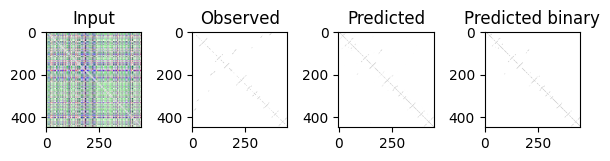

Epoch [1/10], Loss: 0.1322, Validation: 0.1605


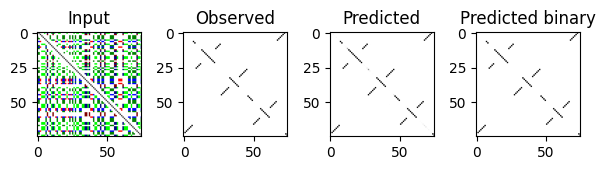

Epoch [2/10], Loss: 0.0811, Validation: 0.18


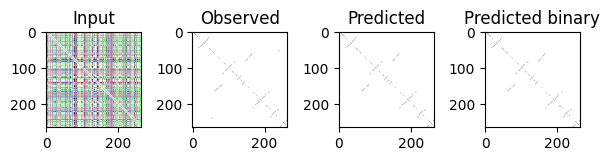

Epoch [3/10], Loss: 0.0647, Validation: 0.1662


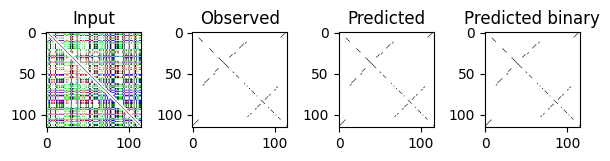

Epoch [4/10], Loss: 0.0547, Validation: 0.1606


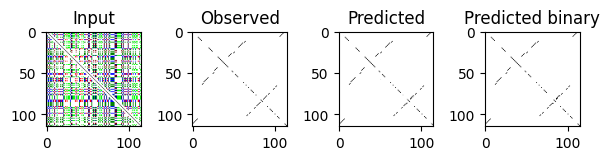

Epoch [5/10], Loss: 0.0476, Validation: 0.1474


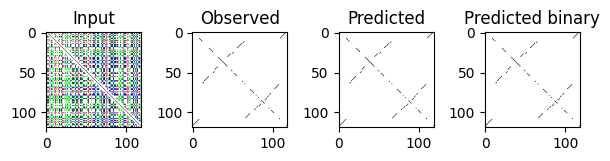

Epoch [6/10], Loss: 0.0421, Validation: 0.1493


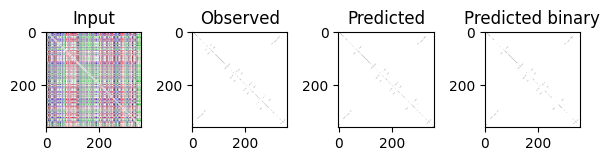

Epoch [7/10], Loss: 0.0383, Validation: 0.1408


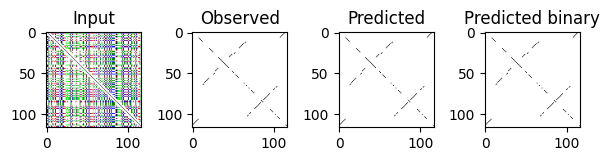

Epoch [8/10], Loss: 0.0352, Validation: 0.1628


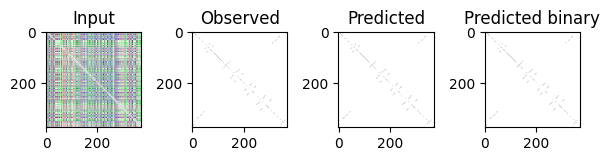

Epoch [9/10], Loss: 0.0325, Validation: 0.1528


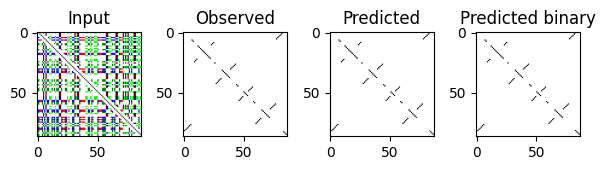

Epoch [10/10], Loss: 0.0304, Validation: 0.1522


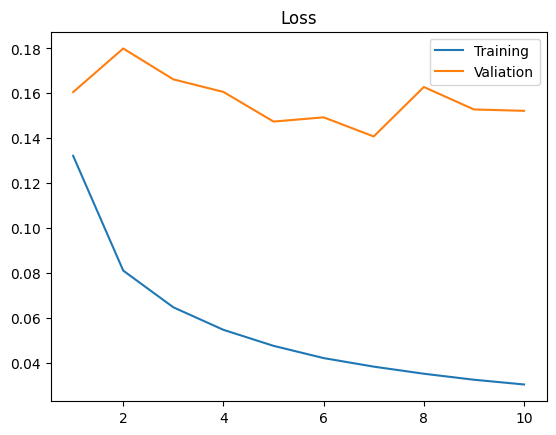

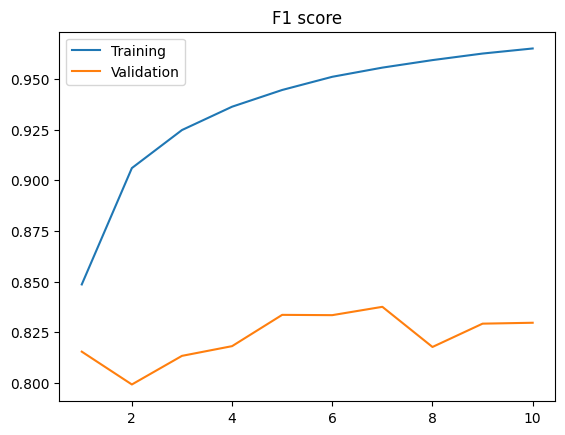

Finished training baseline



In [13]:
modeldict = ("baseline", utils.RNA_Unet())
df = fit_model(modeldict, loss_weight = False, output_file = '/content/drive/MyDrive/results/RNAunet_experiment3.csv')

## Large

Training with large...


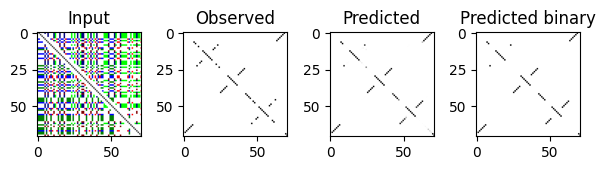

Epoch [1/10], Loss: 0.1458, Validation: 0.1955


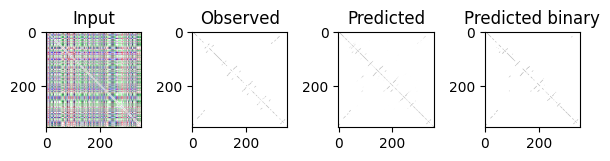

Epoch [2/10], Loss: 0.0876, Validation: 0.2523


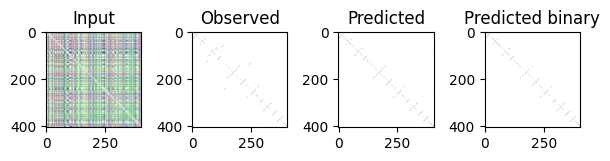

Epoch [3/10], Loss: 0.0713, Validation: 0.2168


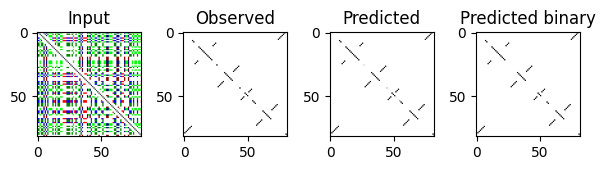

Epoch [4/10], Loss: 0.0611, Validation: 0.2421


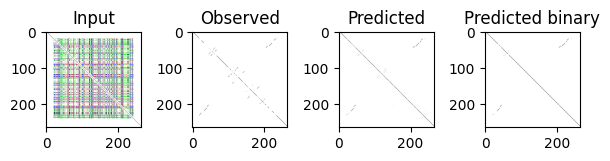

Epoch [5/10], Loss: 0.054, Validation: 0.2146


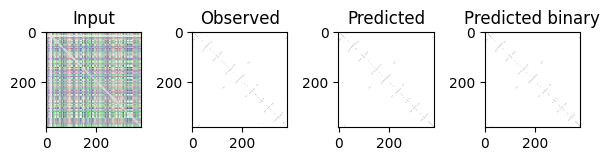

Epoch [6/10], Loss: 0.0486, Validation: 0.3025


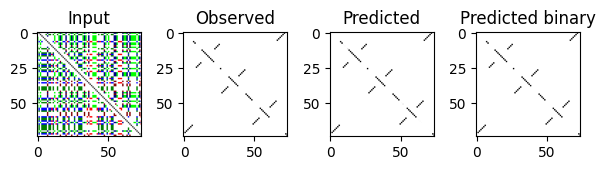

Epoch [7/10], Loss: 0.0446, Validation: 0.2189


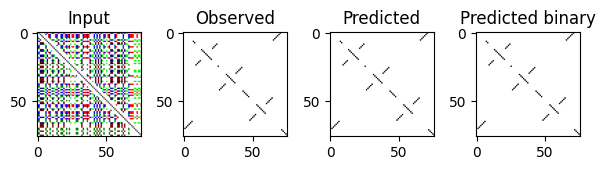

Epoch [8/10], Loss: 0.041, Validation: 0.2546


In [ ]:
modeldict = ("large", RNA_Unet_large())
df = fit_model(modeldict, loss_weight = False, output_file = '/content/drive/MyDrive/results/RNAunet_experiment3.csv', df = df)

## Multi-task learning

In [ ]:
modeldict = ("multi-task", RNA_Unet_multi())
df = fit_model(modeldict, loss_weight = 0.5, output_file = '/content/drive/MyDrive/results/RNAunet_experiment3.csv', df = df)

## Multi-task learning large

In [ ]:
modeldict = ("multi-task large", RNA_Unet_multi_large())
df = fit_model(modeldict, loss_weight = 0.5, output_file = '/content/drive/MyDrive/results/RNAunet_experiment3.csv', df = df)

## Plots

In [ ]:
utils.plot_loss_curves(df, output_file = '/content/drive/MyDrive/figures/RNAunet_experiment3_loss.png')
utils.plot_f1_curves(df, output_file = '/content/drive/MyDrive/figures/RNAunet_experiment3_f1.png')